=== Experiment with Standard SGD ===
MSE on Task 1 after training on Task 1: 0.000183
MSE on Task 1 after training on Task 2 (similar): 0.362654
MSE on Task 1 after training on Task 3 (different): 1.026326

=== Experiment with OGD ===
MSE on Task 1 after training on Task 1: 0.000218
MSE on Task 1 after training on Task 2 with OGD: 0.099431
MSE on Task 1 after training on Task 3 with OGD: 0.146633


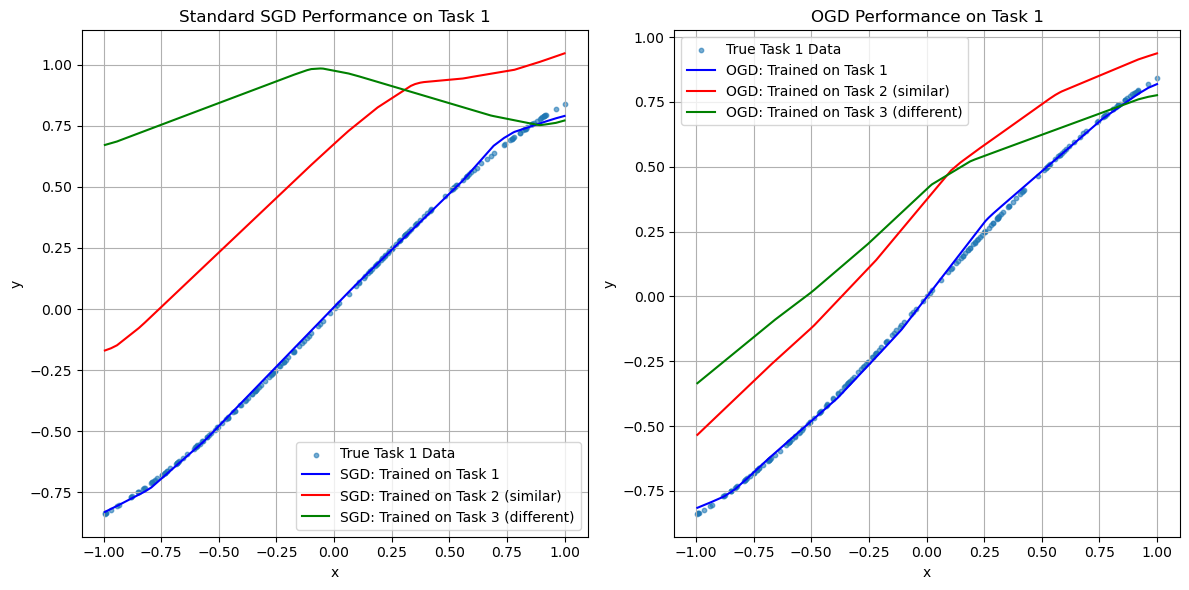

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

# Set the device to CPU
device = torch.device("cpu")

# ---------------------------
# Reproducibility Settings
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 16)  # Input layer: 1 input -> 32 neurons
        self.fc2 = nn.Linear(16, 16)  # Hidden layer: 32 -> 32 neurons
        self.fc3 = nn.Linear(16, 1)  # Output layer: 32 -> 1 output

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation for first layer
        x = F.relu(self.fc2(x))  # ReLU activation for second layer
        x = self.fc3(x)           # Linear output
        return x

# Function to generate data for a given function
def generate_data(func, num_samples, interval=[-1, 1]):
    x = torch.rand(num_samples, 1) * (interval[1] - interval[0]) + interval[0]
    y = func(x)
    return x.to(device), y.to(device) # Move data to CPU

# Standard SGD training function
def train_sgd(model, optimizer, train_loader, epochs=50):
    model.train()
    for _ in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # Move batch to CPU
            optimizer.zero_grad()
            output = model(batch_x)
            loss = F.mse_loss(output, batch_y)
            loss.backward()
            optimizer.step()

# OGD training function
def train_ogd(model, optimizer, train_loader_new, train_loader_prev, epochs=50):
    model.train()
    for _ in range(epochs):
        # Zip loaders to get batches from both current and previous tasks
        for (batch_x_new, batch_y_new), (batch_x_prev, batch_y_prev) in zip(train_loader_new, train_loader_prev):
            batch_x_new, batch_y_new = batch_x_new.to(device), batch_y_new.to(device) # Move batch to CPU
            batch_x_prev, batch_y_prev = batch_x_prev.to(device), batch_y_prev.to(device) # Move batch to CPU

            optimizer.zero_grad()

            # Compute gradient for the new task
            output_new = model(batch_x_new)
            loss_new = F.mse_loss(output_new, batch_y_new)
            grad_new = torch.autograd.grad(loss_new, model.parameters(), retain_graph=True)
            grad_new_flat = torch.cat([g.view(-1) for g in grad_new]).to(device) # Move to CPU

            # Compute gradient for the previous task
            output_prev = model(batch_x_prev)
            loss_prev = F.mse_loss(output_prev, batch_y_prev)
            grad_prev = torch.autograd.grad(loss_prev, model.parameters(), retain_graph=True)
            grad_prev_flat = torch.cat([g.view(-1) for g in grad_prev]).to(device) # Move to CPU

            # Orthogonal projection
            if torch.norm(grad_prev_flat) > 1e-8:  # Avoid division by zero
                proj = (grad_new_flat @ grad_prev_flat) / (grad_prev_flat @ grad_prev_flat) * grad_prev_flat
                projected_grad_flat = grad_new_flat - proj
            else:
                projected_grad_flat = grad_new_flat

            # Assign projected gradients back to model parameters
            start = 0
            for param in model.parameters():
                numel = param.numel()
                param.grad = projected_grad_flat[start:start + numel].view(param.shape)
                start += numel

            optimizer.step()

# Evaluation function
def evaluate(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(x_test.to(device)) # Move x_test to CPU
        mse = F.mse_loss(output, y_test.to(device)).item() # Move y_test to CPU
    return mse

# Main experiment
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate data for all tasks
    x_test1, y_test1 = generate_data(lambda x: torch.sin(x), 200)
    x_train1, y_train1 = generate_data(lambda x: torch.sin(x), 800)
    x_train2, y_train2 = generate_data(lambda x: torch.sin(x + .75), 800)
    x_train3, y_train3 = generate_data(lambda x: torch.cos(x), 800)

    # Create DataLoaders
    train_loader1 = DataLoader(TensorDataset(x_train1, y_train1), batch_size=32, shuffle=True)
    train_loader2 = DataLoader(TensorDataset(x_train2, y_train2), batch_size=32, shuffle=True)
    train_loader3 = DataLoader(TensorDataset(x_train3, y_train3), batch_size=32, shuffle=True)

    # Variables to store predictions for plotting
    global x_plot, y_true_plot, y_sgd_task1, y_sgd_task2, y_sgd_task3, y_ogd_task1, y_ogd_task2, y_ogd_task3
    x_plot = x_test1.cpu().numpy() # Move to CPU for plotting
    y_true_plot = y_test1.cpu().numpy() # Move to CPU for plotting

    # Experiment 1: Standard SGD
    print("=== Experiment with Standard SGD ===")
    model = Net().to(device) # Move model to CPU
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train on Task 1
    train_sgd(model, optimizer, train_loader1)
    mse1_initial = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 1: {mse1_initial:.6f}")
    with torch.no_grad():
        y_sgd_task1 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting
    torch.save(model.state_dict(), 'model_task1.pth')

    # Train on Task 2 after Task 1
    model.load_state_dict(torch.load('model_task1.pth'))
    model.to(device) # Ensure model is on CPU after loading
    train_sgd(model, optimizer, train_loader2)
    mse1_after_task2 = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 2 (similar): {mse1_after_task2:.6f}")
    with torch.no_grad():
        y_sgd_task2 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting

    # Train on Task 3 after Task 1
    model.load_state_dict(torch.load('model_task1.pth'))
    model.to(device) # Ensure model is on CPU after loading
    train_sgd(model, optimizer, train_loader3)
    mse1_after_task3 = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 3 (different): {mse1_after_task3:.6f}")
    with torch.no_grad():
        y_sgd_task3 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting

    # Experiment 2: OGD
    print("\n=== Experiment with OGD ===")
    model = Net().to(device) # Move model to CPU
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train on Task 1
    train_sgd(model, optimizer, train_loader1)
    mse1_initial_ogd = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 1: {mse1_initial_ogd:.6f}")
    with torch.no_grad():
        y_ogd_task1 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting
    torch.save(model.state_dict(), 'model_task1_ogd.pth')

    # Train on Task 2 with OGD
    model.load_state_dict(torch.load('model_task1_ogd.pth'))
    model.to(device) # Ensure model is on CPU after loading
    train_ogd(model, optimizer, train_loader2, train_loader1)
    mse1_after_task2_ogd = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 2 with OGD: {mse1_after_task2_ogd:.6f}")
    with torch.no_grad():
        y_ogd_task2 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting

    # Train on Task 3 with OGD
    model.load_state_dict(torch.load('model_task1_ogd.pth'))
    model.to(device) # Ensure model is on CPU after loading
    train_ogd(model, optimizer, train_loader3, train_loader1)
    mse1_after_task3_ogd = evaluate(model, x_train1, y_train1)
    print(f"MSE on Task 1 after training on Task 3 with OGD: {mse1_after_task3_ogd:.6f}")
    with torch.no_grad():
        y_ogd_task3 = model(x_test1.to(device)).cpu().numpy() # Move to CPU for plotting

if __name__ == "__main__":
    main()

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_plot, y_true_plot, label='True Task 1 Data', alpha=0.6, s=10)
plt.plot(np.sort(x_plot, axis=0), y_sgd_task1[np.argsort(x_plot, axis=0)].flatten(), label='SGD: Trained on Task 1', color='blue')
plt.plot(np.sort(x_plot, axis=0), y_sgd_task2[np.argsort(x_plot, axis=0)].flatten(), label='SGD: Trained on Task 2 (similar)', color='red')
plt.plot(np.sort(x_plot, axis=0), y_sgd_task3[np.argsort(x_plot, axis=0)].flatten(), label='SGD: Trained on Task 3 (different)', color='green')
plt.title('Standard SGD Performance on Task 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_plot, y_true_plot, label='True Task 1 Data', alpha=0.6, s=10)
plt.plot(np.sort(x_plot, axis=0), y_ogd_task1[np.argsort(x_plot, axis=0)].flatten(), label='OGD: Trained on Task 1', color='blue')
plt.plot(np.sort(x_plot, axis=0), y_ogd_task2[np.argsort(x_plot, axis=0)].flatten(), label='OGD: Trained on Task 2 (similar)', color='red')
plt.plot(np.sort(x_plot, axis=0), y_ogd_task3[np.argsort(x_plot, axis=0)].flatten(), label='OGD: Trained on Task 3 (different)', color='green')
plt.title('OGD Performance on Task 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
x_train1, y_train1 = generate_data(lambda x: x, 800)
x_train2, y_train2 = generate_data(lambda x: 1.05 * x + .05, 800)
x_train3, y_train3 = generate_data(lambda x: x**2, 800)

In [3]:
sorted_tensor1, _ = torch.sort(x_train1, dim=0)
sorted_tensor2, _ = torch.sort(x_train2, dim=0)
sorted_tensor3, _ = torch.sort(x_train3, dim=0)

In [4]:
common_elements = sorted_tensor2[torch.isin(sorted_tensor1, sorted_tensor2)]

print("Common elements:", common_elements)

Common elements: tensor([])
